# M68 Music Board DAC Convertor

In this notebook I figure out how to make sounds from a old SWTPC Music Board
The remanufactured card is based on a **Model 68 Music Board** 
originally created by Newtech Computer Systems

The code below asssumes an R-2R Resistor Ladder with the voltages output as in the array **v**

### Create table of all possible voltages from DAC

In [42]:
import csv
import numpy as np
import math

# Voltages measured from the DAC at the 6 bit positions. 
v = [0.08,0.16,0.31,2.55,1.275,0.6375]

# make m the max value of 6 bits
m = 0xff
m = m >> 2

allvalues = []

# Create a file containing all possible values 
with open('raw-bitdata.csv', 'w', newline='') as f:
    writer = csv.writer(f)    
    writer.writerow(['value 8 bit',"value 6 bit", "hex string","voltage","binary"])
    x = range(m)
    for n in x:
        outV = 0
        val = n
        for b in range(6):
            bit = val&0x1
            outV = outV +  v[b]*bit
            val = val >> 1

        hv = n<<2   
        allvalues.append([hv,outV/5])
        writer.writerow([hv, n, '0x' + hex(hv).upper()[2:],outV,bin(n)])




### Sort the array of voltages to create lookup table. 

In [43]:
# Sort all the values so I can build a ladder of values. 
a = np.array(allvalues)
a = a[a[:,1].argsort()[::-1]]


hvalues = a[:,0] # Sorted hex valuues corresponding to voltages
values = a[:,1] # Sorted voltage values

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_index(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

idx = find_nearest_index(values, 0.72)
print("for 0.72 index = ", idx)

# 0 to 63 ... as a sine wave

for 0.72 index =  17


### Create Assembly Language Data for Sine Wave

In [44]:
m68code = "WAVE    fcb "
with open('sine-table.csv', 'w', newline='') as f:
    writer = csv.writer(f)    
    #writer.writerow(['value 8 bit',"value 6 bit", "hex string","voltage","binary"])
    steps = 64
    maxitemsperline = 16
    itemsonline = maxitemsperline
    for i in range(steps):
        # 63 is half a sine wave so +ve pi to -ve pi
        inp = i/steps*(2*3.1415)
        isin = (math.sin(inp) + 1) /2    
        ival = find_nearest_index(values, isin)
        iv = int(hvalues[ival])
        value = values[ival]
        writer.writerow([inp, isin, ival, value, iv, '0x' + hex(iv).upper()[2:], bin(iv)])
        # Avoid zero in byte values so I can use $00 as terminator
        if iv==0:
            iv = 1
        hvs = hex(iv).upper()[2:]
        if len(hvs) < 2:
            hvs = "0"+hvs
        m68code+='$'+hvs
        itemsonline-=1
        if (itemsonline>0):
            m68code+=','
        else:
            itemsonline = maxitemsperline
            m68code+='\r\n        fcb '
    m68code+='$00'
print("Done!")
print(m68code)

Done!
WAVE    fcb $DC,$28,$38,$A0,$AC,$B8,$64,$6C,$78,$E0,$E4,$EC,$F0,$F4,$F8,$F8
        fcb $F8,$F8,$F8,$F4,$F0,$EC,$E4,$E0,$78,$6C,$64,$B8,$AC,$A0,$38,$28
        fcb $DC,$D0,$C4,$58,$4C,$44,$98,$90,$84,$1C,$14,$10,$08,$04,$04,$01
        fcb $01,$01,$04,$04,$08,$10,$14,$1C,$84,$90,$98,$44,$4C,$58,$C4,$D0
        fcb $00


#### Chart of hex values corresponding to increasing voltages

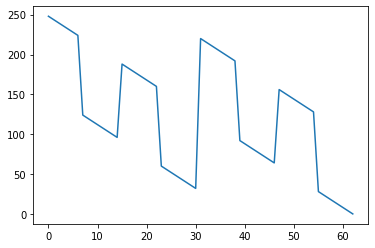

In [45]:
import matplotlib.pyplot as plt
plt.plot(hvalues)
plt.show()



## Lets play an audio wav file!

### First load the wav file into arrays. 

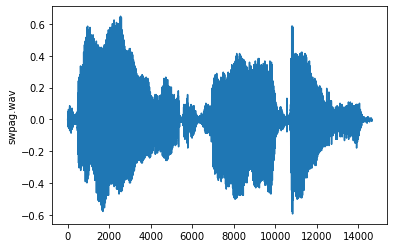

In [46]:
import soundfile as sf
import matplotlib.pyplot as plt

soundfile = 'swpag.wav'

data_in, datasamplerate = sf.read(soundfile)
plt.plot(data_in)
plt.ylabel(soundfile)
plt.show()

### Down-sample the data  to 8KHz

In [47]:
import samplerate
converter = 'sinc_best'  # or 'sinc_fastest', ...
ratio = 8000.0/datasamplerate
data = samplerate.resample(data_in, ratio, converter)
print(data)
maxValue = max(data)
minValue = min(data)
print("len", len(data))
print("max", max(data))
print("min", min(data))
vrange = (maxValue - minValue) 
print("range ", vrange)
values

[ 0.00067307 -0.00077069  0.00086243 ... -0.00024712 -0.00757504
 -0.00803983]
len 14667
max 0.6483861
min -0.59153265
range  1.2399187


array([0.9865, 0.9705, 0.9545, 0.9405, 0.9245, 0.9085, 0.8925, 0.875 ,
       0.859 , 0.843 , 0.827 , 0.813 , 0.797 , 0.781 , 0.765 , 0.7475,
       0.7315, 0.7155, 0.6995, 0.6855, 0.6695, 0.6535, 0.6375, 0.62  ,
       0.604 , 0.588 , 0.572 , 0.558 , 0.542 , 0.526 , 0.51  , 0.4925,
       0.4765, 0.4605, 0.4445, 0.4305, 0.4145, 0.3985, 0.3825, 0.365 ,
       0.349 , 0.333 , 0.317 , 0.303 , 0.287 , 0.271 , 0.255 , 0.2375,
       0.2215, 0.2055, 0.1895, 0.1755, 0.1595, 0.1435, 0.1275, 0.11  ,
       0.094 , 0.078 , 0.062 , 0.048 , 0.032 , 0.016 , 0.    ])

### Output the wave file data for inclusion in assemler program

In [48]:


m68code = "WAVE    fcb "
maxitemsperline = 16
itemsonline = maxitemsperline
for v in data:
    # scale v to between 0 and 1
    isin = (v-minValue)/vrange   
    ival = find_nearest_index(values, isin)
    iv = int(hvalues[ival])
    value = values[ival]

    if iv==0:
        iv = 4
    hvs = hex(iv).upper()[2:]
    if len(hvs) < 2:
        hvs = "0"+hvs
    m68code+='$'+hvs
    itemsonline-=1
    if (itemsonline>0):
        m68code+=','
    else:
        itemsonline = maxitemsperline
        m68code+='\r\n        fcb '
m68code+='$01'
print("Done!")
print(m68code)    

Done!
WAVE    fcb $D8,$D8,$D8,$D8,$D8,$D8,$D8,$D0,$20,$D8,$D4,$DC,$D4,$D8,$D8,$D8
        fcb $20,$D8,$D8,$DC,$D0,$20,$D0,$D4,$D8,$D0,$DC,$D0,$DC,$D8,$D8,$20
        fcb $D4,$20,$D4,$20,$DC,$D8,$20,$D0,$24,$D0,$20,$D8,$D0,$20,$CC,$DC
        fcb $D4,$D4,$DC,$D0,$DC,$D4,$D4,$D8,$D0,$D8,$D8,$D0,$DC,$D0,$D4,$D8
        fcb $CC,$DC,$D0,$D8,$D0,$D8,$D4,$D4,$20,$CC,$20,$D8,$D4,$20,$D0,$20
        fcb $D8,$D8,$20,$D8,$DC,$DC,$D8,$DC,$D8,$20,$D4,$DC,$20,$D0,$28,$D4
        fcb $D8,$24,$CC,$24,$D8,$D4,$28,$D4,$20,$D8,$DC,$DC,$D4,$24,$D0,$20
        fcb $D4,$20,$D8,$D4,$24,$CC,$24,$DC,$D0,$24,$D0,$DC,$DC,$D0,$24,$D0
        fcb $20,$D8,$DC,$D4,$D8,$DC,$D0,$20,$D0,$20,$D0,$DC,$D8,$D0,$20,$D4
        fcb $D8,$DC,$D0,$20,$D4,$D8,$D8,$D4,$D8,$D8,$D4,$D8,$DC,$D0,$D8,$DC
        fcb $CC,$20,$D0,$D4,$24,$C8,$20,$CC,$D4,$DC,$C8,$20,$D0,$D8,$DC,$D0
        fcb $24,$CC,$DC,$D8,$D0,$DC,$D0,$D8,$D8,$D4,$D8,$D4,$DC,$D0,$D8,$D8
        fcb $D0,$DC,$D0,$D8,$D4,$D8,$D8,$D4,$D8,$D8,$D8,$D0,$DC,$D0,$DC,$20
      